In [1]:
#THIS NOTEBOOK ALLOWS YOU TO PLAY WITH THE PARAMETERS FROM THE MODEL IN NIETO ET AL. (2021)

In [1]:
#IMPORT LIBRARIES
import matplotlib
import matplotlib.pyplot as plt
import pylab
import numpy as np
from scipy.integrate import odeint
import itertools
import subprocess
import pandas as pd

In [7]:
#READ DATA FUNCTIONS
def get_key(df, key):
    kL=df[key].tolist()
    kM={}
    for k in kL:
        kM[k]=1
    kL=[]
    for k in kM:
        kL.append(k)
    return sorted(kL)

def read_data():
    DF=pd.read_csv('data/daylength_def.csv')
    mut=get_key(DF,'Genotype')
    Length=get_key(DF,'Daylength')
    Temp=get_key(DF,'Temperature')    
    avgdata={}
    stddata={}
    for m in mut:
        DFm=DF[DF.Genotype==m]
        m=m.replace(' ','_')
        avgdata[m]={}
        stddata[m]={}
        for d,t in itertools.product(Length,Temp):
            key=str(t)+'_'+str(d)
            DFnew=DFm[(DFm.Daylength==d) & (DFm.Temperature==t)]
            avgdata[m][key]=DFnew.Growth.mean()
            stddata[m][key]=DFnew.Growth.std()
    return avgdata, stddata
            
#READ DATA
avgdata, stddata=read_data()

In [14]:
#DEFINE MODEL

#IS IT DAY? 1=YES, 0=NO
def is_day(t,Daylength):
    t1=t%24-Daylength
    return 1-np.heaviside(t1,1)

#ELF3 TRANSCRIPTION
def elf3p(t,Daylength,pE1,pE2):  
    k0=5
    t2=t-Daylength
    t3=t-24.0
    
    if Daylength==0:
        return pE1+pE2
    elif Daylength==24:
        return pE1-pE2    
    else:
        SigT=2.0/(1.0+np.exp(-k0*t))
        SigT2=2.0/(1.0+np.exp(-k0*t2))
        SigT3=2.0/(1.0+np.exp(-k0*t3))
        return pE1-pE2*(-1.0+SigT-SigT2+SigT3)

#COMPLETE MODEL
def growth(y, t, Temp, Day, mut, Par):
    #Variables
    B=y[0]#PHYB
    E=y[1]#ELF3
    P=y[2]#PIFs
    C=y[3]#COP1
    H=y[4]#Hypocotyl growth
    #Variables
    B=y[0]#PHYB
    E=y[1]#ELF3
    P=y[2]#PIF
    C=y[3]#COP1
    G=y[4]#Hypocotyl
    #Parameters
    t1=t%24
    L=is_day(t1,Day)
    pB=10.0
    kr=Par.kr22#0.232 
    pE1=Par.pE122
    pE2=Par.pE222
    dE=Par.dE
    pP=1.0#adimensional
    pPE=Par.pPE22
    dP=Par.dP
    kPC=Par.kPC
    dPB=Par.dPB
    pCL=1.0#adimensional
    pCD=Par.pCD
    dC=Par.dC
    pG=Par.pG
    kG=Par.kG
    pGP=Par.pGP
    pGE=Par.pGE
    pGB=Par.pGB
    pGH=Par.pGH
    pHC=Par.pHC
    mB=1.0#maximum PHYB value
    
    if Temp==28:
        pB=Par.pB28
        kr=Par.kr28#0.411 (Casal's lab data)
        pE1=Par.pE128
        pE2=Par.pE228
        pPE=Par.pPE28
        pCL=Par.pCL28
    if 'PHYBox' in mut:
        mB*=Par.mutBox
    if 'ELF3ox' in mut:
        pE1*=Par.mutEox
    if 'PIF4ox' in mut:
        pP*=Par.mutPox
    if 'pif4' in mut:
        pP*=Par.mutPko1
    if 'pifq' in mut:
        pP*=Par.mutPko2
    if 'COP1' in mut:
        pCL*=Par.mutCox
        pCD*=Par.mutCox
    if 'cop1-4' in mut:
        pCL*=Par.mutCko1
        pCD*=Par.mutCko1
    if 'cop1-6' in mut:
        pCL*=Par.mutCko2
        pCD*=Par.mutCko2
    if 'hy5' in mut:
        pGH=0
        
    #Equations
    dBdt=pB*L*(mB-B)-kr*B
    dEdt=elf3p(t1,Day,pE1,pE2)-dE*E
    dPdt=pP/(1+pPE*E)-dP*P/(1+kPC*C)-dPB*P*B
    dCdt=pCL*L+pCD*(1-L)-dC*C
    dGdt=pG+kG*pGP*P/(1+pGP*P+pGE*E+pGB*B+pGH/(1+pHC*C))
        
    if 'elf3-8' in mut:
        dEdt=0
    if 'phyB' in mut:
        dBdt=0
    dydt=[dBdt, dEdt, dPdt, dCdt, dGdt]
    return dydt     

In [9]:
#DEFINE PARAMETERS CLASS
class Parameters:
    def __init__(self, params):
        self.pB28=params[0]
        self.kr22=params[1]
        self.kr28=params[2]
        self.pE122=params[3]        
        self.pE128=params[4]
        self.pE222=params[5]
        self.pE228=params[6]
        self.dE=params[7]
        self.pPE22=params[8]
        self.pPE28=params[9]
        self.dP=params[10]
        self.kPC=params[11]
        self.dPB=params[12]
        self.pCL28=params[13]
        self.pCD=params[14]
        self.dC=params[15]
        self.pG=params[16]
        self.kG=params[17]
        self.pGP=params[18]
        self.pGE=params[19]
        self.pGB=params[20]
        self.pGH=params[21]
        self.pHC=params[22]
        #MUTPARS
        self.mutBox=params[23]
        self.mutEox=params[24]
        self.mutPox=params[25]
        self.mutPko1=params[26]
        self.mutPko2=params[27]
        self.mutCox=params[28]
        self.mutCko1=params[29]
        self.mutCko2=params[30]

#INITIALIZE PARAMETERS
Temp=[22,28]
Daylength=[0,8,12,16,24]
Daylength_sim=range(0,25)
Daylength_sim=list(Daylength)
params=[]
with open('results/parameters_paper.txt', 'r') as f:
    for line in f:
        w=line.split()
        params.append(float(w[0]))
Params=Parameters(params)

In [15]:
#MODIFY PARAMETERS BY CHANGING ITS VALUE MANUALLY
#IF YOU WANT TO GO BACK TO THE DEFAULT PARAMETERS,
#JUST RUN THE PREVIOUS CELL AGAIN
Params.kr22=0.5

0.3315

In [ ]:
#SIMULATE SOME MUTANTS FOR WHICH WE HAVE GROWTH DATA
mutants=['Col', 'cop1-4', 'COP1-OE', 'pif4', 'elf3-8', 'elf3-8_cop1-4',
         'ELF3ox', 'ELF3ox_cop1-4', 'hy5', 'phyB-9', 'PHYBox', 
         'pif4', 'PIF4ox', 'pifq']
#MODEL PREDICTIONS
mutants.append('elf3-8_phyB')
#Test new double mutants
mutants+=['phyB_cop1-4', 'phyB_COP1-OE', 'PHYBox_COP1-OE']
#EVEN TRIPLE MUTANTS
mutants+=['phyB_cop1-4_elf3-8', 'phyB_COP1-OE_elf3-8', 'phyB_cop1-4_ELF3ox']
#PREDICTION
hypo={}
for mut in mutants:
    hypo[mut]={}
    for T,D in itertools.product(Temp,Daylength_sim):
        key=str(T)+'_'+str(D)
        y0=[0,0,0,0,0]
        time=np.linspace(0,120,500)
        sol=odeint(growth, y0, time, args=(T, D, mut, Params))
        R=sol[-1,4]
        hypo[mut][key]=R

/home/pcatalan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
/home/pcatalan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator


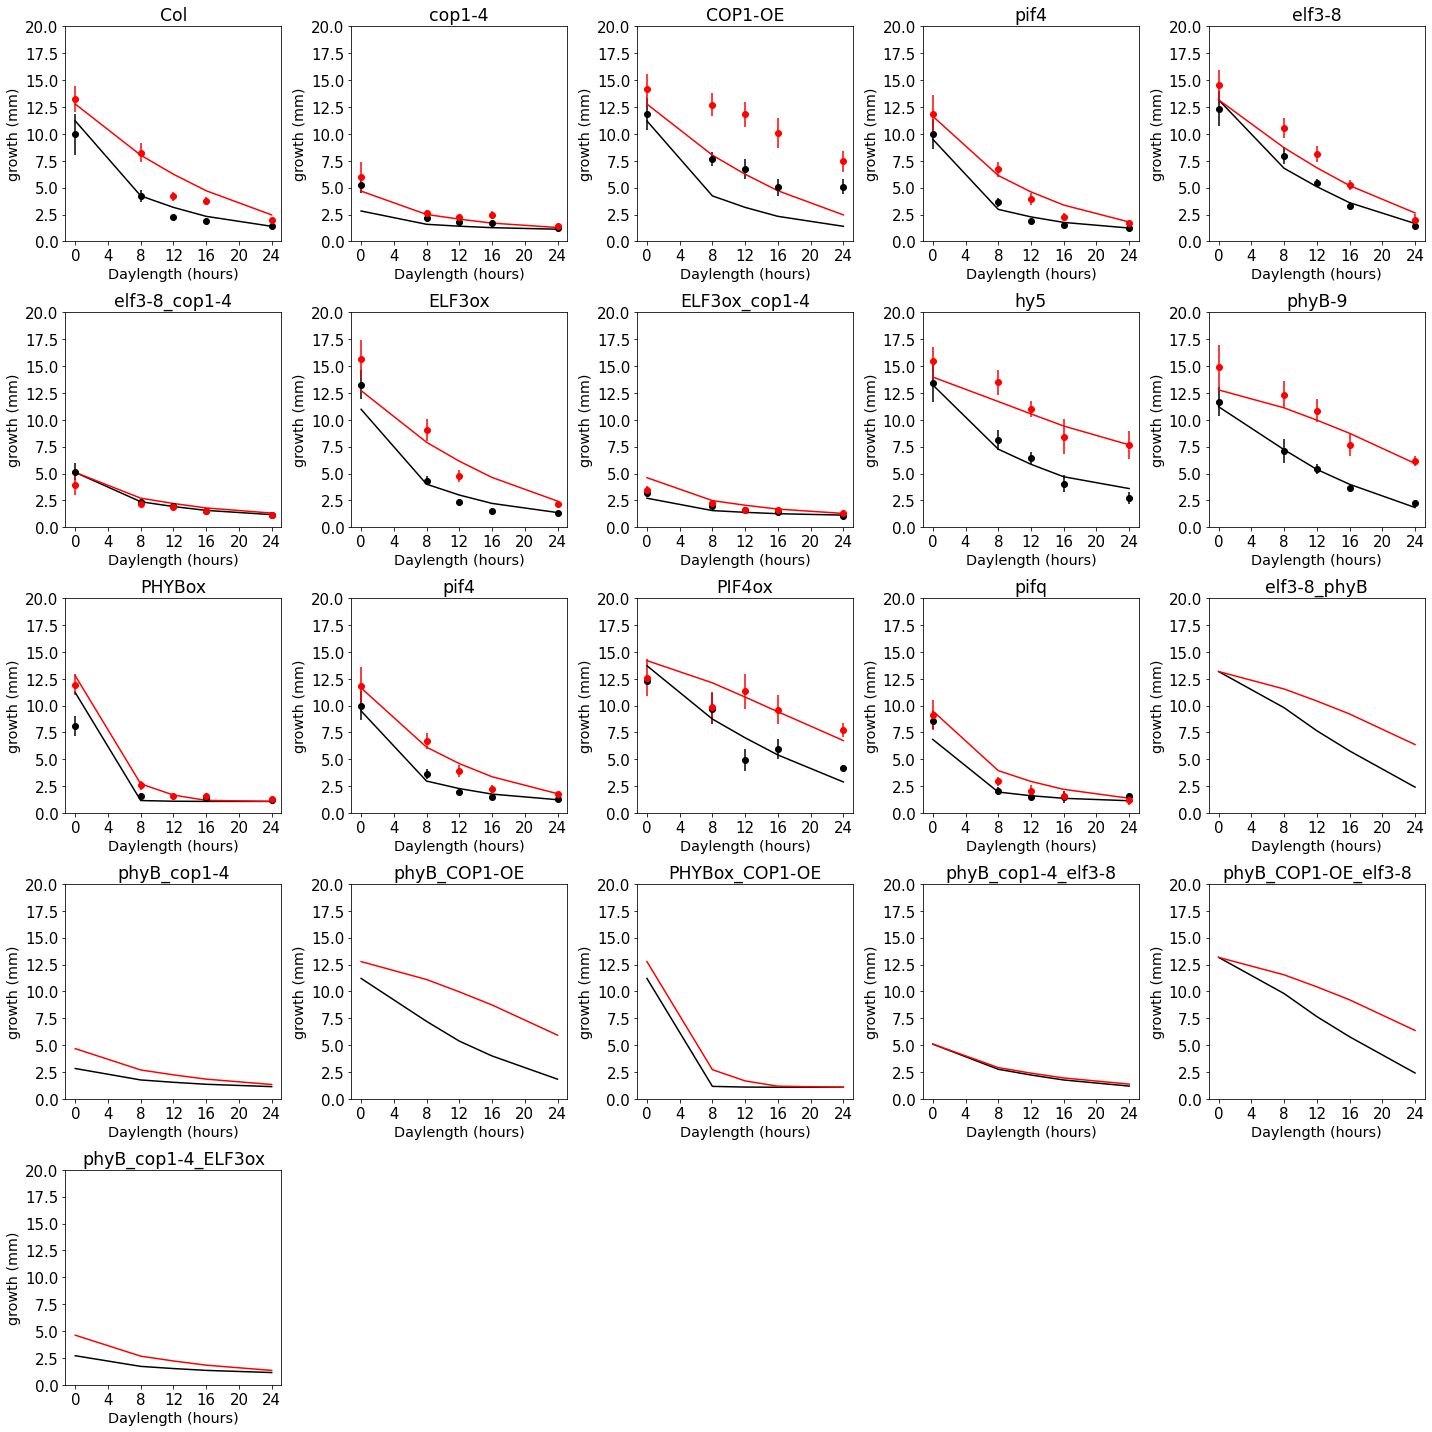

In [13]:
#PLOT RESULTS VERSUS DATA
def plot_data(ax, mut, avgdata, stddata, Daylength):
    d22=[]
    d28=[]
    s22=[]
    s28=[]
    #DATA
    for D in Daylength:
        key22='22_'+str(D)
        key28='28_'+str(D)
        d22.append(avgdata[key22])
        d28.append(avgdata[key28])
        s22.append(stddata[key22])
        s28.append(stddata[key28])
    ax.errorbar(Daylength, d22, yerr=s22, fmt='o', color='k')
    ax.errorbar(Daylength, d28, yerr=s28, fmt='o', color='r')
    
def plot_sims(ax, mut, sim, Daylength_sim):
    h22=[]
    h28=[]
    #SIMULATIONS
    for D in Daylength_sim:
        key22='22_'+str(D)
        key28='28_'+str(D)
        h22.append(sim[key22])
        h28.append(sim[key28])  
    ax.plot(Daylength_sim, h22, 'k')
    ax.plot(Daylength_sim, h28, 'r')
    #TEXT
    ax.set_title(mut, size='xx-large')
    ax.set_ylim([0,20])
    ax.set_xlabel('Daylength (hours)', size='x-large')
    ax.set_ylabel('growth (mm)', size='x-large')
    ax.set_xticks([0,4,8,12,16,20,24])
    ax.set_xticklabels([0,4,8,12,16,20,24], size=15)
    ax.set_yticklabels(ax.get_yticks(), size=15)
    
    
fig=plt.figure(figsize=(20,20))
ncols=5
nrows=len(mutants)/5+1
for i1,mut in enumerate(mutants):
    ax=fig.add_subplot(nrows,ncols,i1+1)
    try:
        plot_data(ax,mut,avgdata[mut],stddata[mut],Daylength)
        plot_sims(ax,mut,hypo[mut],Daylength_sim)
    except:
        plot_sims(ax,mut,hypo[mut],Daylength_sim)
fig.tight_layout()
